# Génération de la Frontière Efficiente de Markowitz

Ce notebook illustre l'utilisation de la méthode de scalarisation pour approximer la frontière efficiente d'un portefeuille d'actions du secteur Energie.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import os

# Charger les données
df = pd.read_csv('../datasets/Information_Technology.csv', index_col=0, parse_dates=True)

for file in os.listdir('../datasets/'):
    if file.endswith('.csv') and 'Information_Technology' not in file:
        temp_df = pd.read_csv(os.path.join('../datasets/', file), index_col=0, parse_dates=True)
        df = df.join(temp_df, how='inner')

In [2]:
df

,AAPL,MSFT,NVDA,AVGO,AMD,INTC,QCOM,TXN,MU,ORCL,...,WELL,EQIX,NEE,DUK,SO,D,AEP,EXC,SRE,XEL
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-02,24.237545,39.858456,0.483038,7.574802,2.670000,27.896452,54.612610,39.557953,33.919167,37.583099,...,50.148026,175.042114,20.032856,53.362503,30.940670,49.050900,41.371311,18.123079,40.092155,25.736317
2015-01-05,23.554739,39.491917,0.474880,7.453717,2.660000,27.581890,54.355274,38.944038,32.972355,37.056019,...,50.767147,173.242676,19.820679,52.594288,30.809048,48.455883,40.762409,17.606934,39.358929,25.444193
2015-01-06,23.556953,38.912292,0.460482,7.284194,2.630000,27.067846,53.583282,38.300499,32.084114,36.673496,...,51.490536,169.466141,19.897663,53.457718,31.178818,48.209023,40.985676,17.471867,38.990528,25.579569
2015-01-07,23.887280,39.406670,0.459282,7.480960,2.580000,27.635595,54.208225,38.988415,31.332521,36.681988,...,51.966248,170.022186,20.079794,53.629158,31.523499,48.405239,41.567505,17.495979,39.620026,25.800449
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-12-26,257.853760,434.901794,139.899521,243.627975,125.059998,20.440001,155.851318,185.700836,89.446556,169.989212,...,124.210960,927.127563,70.180817,104.529366,80.157600,51.844440,88.959755,36.136345,85.451744,65.988266
2024-12-27,254.439240,427.377319,136.980164,240.043442,125.190002,20.299999,154.583130,185.168137,88.261497,167.296021,...,122.844925,921.526001,69.928688,104.558319,80.447891,52.056801,89.394608,36.117046,85.607788,65.949562


In [3]:
# Calcul des rendements logarithmiques
returns = np.log(df / df.shift(1)).dropna()

# Calcul des paramètres pour l'optimisation
mu = returns.mean() * 252  # Annualisation (252 jours boursiers)
Sigma = returns.cov() * 252  # Annualisation de la matrice de covariance
num_assets = len(mu)

In [4]:
returns

,AAPL,MSFT,NVDA,AVGO,AMD,INTC,QCOM,TXN,MU,ORCL,...,WELL,EQIX,NEE,DUK,SO,D,AEP,EXC,SRE,XEL
Date,,,,,,,,,,,,,,,,,,,,,
2020-09-17,-0.016092,-0.010491,-0.004084,-0.003056,-0.001436,-0.000993,0.002790,0.005141,0.015219,-0.004146,...,-0.035533,-0.015352,-0.002965,-0.002833,0.004307,-0.022055,-0.005234,-0.009142,0.001571,-0.035595
2020-09-18,-0.032234,-0.012497,-0.022250,-0.017061,-0.021390,-0.008582,-0.037155,-0.012470,-0.004719,-0.007171,...,-0.023287,-0.004749,-0.009345,-0.019696,-0.013355,-0.023578,-0.015867,-0.024227,-0.008714,-0.022759
2020-09-21,0.029875,0.010672,0.026553,-0.013244,0.039385,-0.003413,0.011051,-0.012190,-0.031838,0.017750,...,-0.040859,-0.008707,-0.002603,-0.004592,0.004157,0.000128,0.007336,-0.009167,-0.028061,-0.003894
2020-09-22,0.015594,0.023808,0.009580,0.027477,-0.003084,0.004615,0.016834,0.012118,0.011129,-0.003294,...,0.009550,0.005951,0.006712,0.001452,0.001696,-0.006046,0.006155,0.013151,0.020280,0.003445
2020-09-23,-0.042851,-0.033483,-0.041522,-0.028046,-0.038974,-0.022882,-0.028970,-0.025494,0.003013,-0.027766,...,-0.051572,-0.026111,-0.017230,-0.017198,-0.011169,-0.015998,-0.008426,-0.020951,-0.038969,-0.010221
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-23,0.003060,-0.003097,0.036232,0.053709,0.044222,0.034243,0.034394,0.017347,-0.004448,-0.003070,...,0.007832,0.013253,0.011376,0.002583,0.002170,0.000373,0.001185,0.008339,0.002646,0.004737
2024-12-24,0.011413,0.009330,0.003930,0.031060,0.013472,0.009852,0.007053,0.012024,-0.004916,0.013332,...,0.007692,0.011029,0.005777,0.003770,0.001444,0.001675,-0.005291,0.005077,0.010514,0.007210
2024-12-27,-0.013331,-0.017453,-0.021088,-0.014822,0.001039,-0.006873,-0.008170,-0.002873,-0.013337,-0.015970,...,-0.011059,-0.006060,-0.003599,0.000277,0.003615,0.004088,0.004876,-0.000534,0.001824,-0.000587


# Calcul des Paramètres d'Optimisation

Les rendements logarithmiques sont calculés comme :

$  r_t = \ln\left(\frac{P_t}{P_{t-1}}\right) $

Le vecteur des rendements moyens annualisés :

$ \mu = \frac{1}{T} \sum_{t=1}^T r_t \times 252 $

La matrice de covariance annualisée :

$ \Sigma = \frac{1}{T} \sum_{t=1}^T (r_t - \bar{r})(r_t - \bar{r})^T \times 252 $


# Méthode de résolution par scalarisation pour générer la frontière efficiente

Fonction rendement : $ F_1(w) = - (w^T \mu) $

Fonction risque : $ F_2(w) = w^T \Sigma w $

Fonction de cout de transaction : $ C(w) = \sum_{i=1}^{N} c_{prop} \cdot |w_i - w_i^{prev}| $

Fonction objectif scalarisée : $ F(w) = \lambda \cdot (w^T \Sigma w) - (1 - \lambda) \cdot (w^T \mu) $

In [5]:
# Définir la fonction objectif pour la scalarisation
def rendement(w, mu):
    return np.dot(w, mu)

def risque(w, Sigma):
    return np.dot(w, np.dot(Sigma, w))

def objective(w, lambda_param):
    portfolio_return = rendement(w, mu)
    portfolio_variance = risque(w, Sigma)
    return lambda_param * portfolio_variance - (1 - lambda_param) * portfolio_return

# Contraintes
constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})  # Sum w_i = 1
bounds = tuple((0, 1) for _ in range(num_assets))  # w_i entre 0 et 1

# Point de départ (portefeuille équipondéré)
initial_guess = np.array(num_assets * [1. / num_assets])

# Générer la frontière efficiente en variant lambda
lambdas = np.linspace(0, 1, 100)  # 100 points entre 0 et 1
frontier_returns = []
frontier_volatilities = []
frontier_weights = []

for lambda_param in lambdas:
    result = minimize(objective, initial_guess, args=(lambda_param,), method='SLSQP', bounds=bounds, constraints=constraints)
    if result.success:
        w_opt = result.x
        frontier_returns.append(rendement(w_opt, mu))
        frontier_volatilities.append(np.sqrt(risque(w_opt, Sigma)))
        frontier_weights.append(w_opt)
    else:
        print(f"Optimization failed for lambda={lambda_param}")

# Convertir en arrays numpy pour faciliter l'analyse
frontier_returns = np.array(frontier_returns)
frontier_volatilities = np.array(frontier_volatilities)

# Génération de la Frontière Efficiente

En faisant varier $ \lambda $ de 0 à 1, nous obtenons différents portefeuilles optimaux.


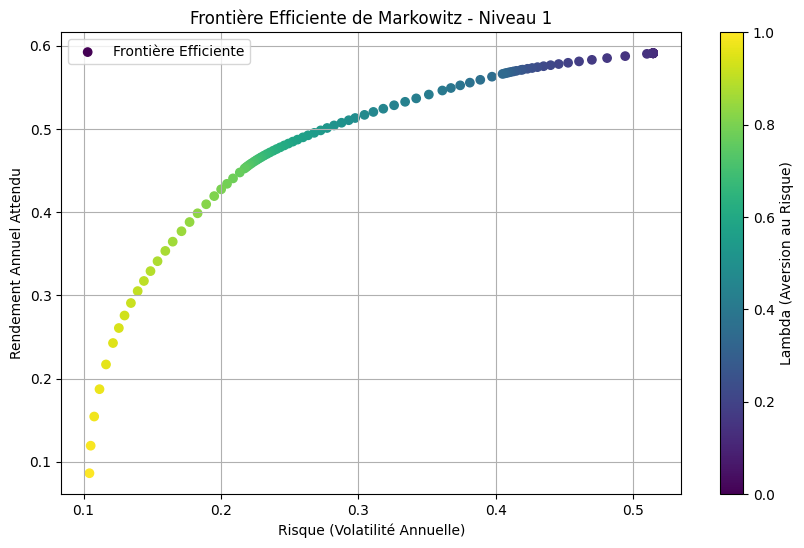

In [6]:
# Tracer la frontière efficiente
plt.figure(figsize=(10, 6))
plt.scatter(frontier_volatilities, frontier_returns, c=lambdas, cmap='viridis', label='Frontière Efficiente')
plt.colorbar(label='Lambda (Aversion au Risque)')
plt.xlabel('Risque (Volatilité Annuelle)')
plt.ylabel('Rendement Annuel Attendu')
plt.title('Frontière Efficiente de Markowitz - Niveau 1')
plt.grid(True)
plt.legend()
plt.show()

In [7]:
c = 0.01  # Coût proportionnel de transaction
w0 = np.array(num_assets * [1. / num_assets])  # Portefeuille

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      100 |     15 |             - |             -
     2 |      150 |     18 |  0.1690175436 |         ideal
     3 |      200 |     29 |  0.1225083261 |         ideal
     4 |      250 |     37 |  0.1422530260 |         ideal
     5 |      300 |     43 |  0.1158252374 |         ideal
     6 |      350 |     54 |  0.0100157785 |         ideal
     7 |      400 |     53 |  0.0177349788 |         ideal
     8 |      450 |     51 |  0.0665111912 |         ideal
     9 |      500 |     47 |  0.1533874662 |         ideal
    10 |      550 |     54 |  0.0588151654 |         ideal
    11 |      600 |     67 |  0.0612502321 |         ideal
    12 |      650 |     74 |  0.0931565069 |         ideal
    13 |      700 |     77 |  0.0724805945 |         nadir
    14 |      750 |     93 |  0.0604613465 |         ideal
    15 |      800 |     89 |  0.0462421005 |         ideal
    16 |      850 |     96 |  0.0976714729 |         ide

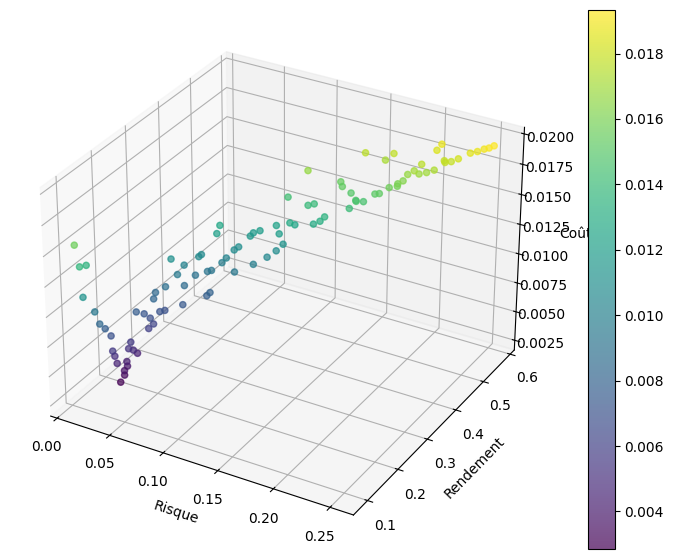

In [16]:
import numpy as np
from pymoo.core.problem import Problem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.optimize import minimize
from pymoo.core.repair import Repair
from pymoo.visualization.scatter import Scatter
import matplotlib.pyplot as plt

class PortfolioRepair(Repair):
    def _do(self, problem, X, **kwargs):
        for i in range(len(X)):
            w = X[i]
            total = np.sum(w)
            if total != 1.0:
                X[i] = w / total
        return X

class PortfolioOptimizationProblem(Problem):
    def __init__(self, mu, cov_matrix, w0, c=0.001):
        n_var = len(mu)
        xl = np.zeros(n_var)
        xu = np.ones(n_var)
        super().__init__(n_var=n_var, n_obj=3, n_constr=0, xl=xl, xu=xu)
        self.mu = mu
        self.cov_matrix = cov_matrix
        self.w0 = w0
        self.c = c

    def _evaluate(self, X, out, *args, **kwargs):
        n_individuals = X.shape[0]
        returns = []
        risks = []
        costs = []

        for i in range(n_individuals):
            w = X[i, :]
            ret = w @ self.mu
            risk = w @ self.cov_matrix @ w
            cost = self.c * np.sum(np.abs(w - self.w0))
            returns.append(ret)
            risks.append(risk)
            costs.append(cost)

        returns = np.array(returns)
        risks = np.array(risks)
        costs = np.array(costs)

        # Gestion de la contrainte via pénalité
        constraint_violation = np.abs(np.sum(X, axis=1) - 1)
        penalty = 1000 * constraint_violation

        out["F"] = np.column_stack([
            -returns + penalty,
            risks + penalty,
            costs + penalty
        ])

# --- Configuration et lancement ---
n_assets = len(mu)
problem = PortfolioOptimizationProblem(mu, Sigma, w0, c)

algorithm = NSGA2(
    pop_size=100,
    n_offsprings=50,
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=20),
    repair=PortfolioRepair(),
    eliminate_duplicates=True
)

res = minimize(problem, algorithm, ('n_gen', 10_000), seed=1, verbose=True)

# --- Vérification et visualisation ---
if res.F is not None:
    optimal_weights = res.X
    objectives = res.F
    returns = -objectives[:, 0]  # On re-inverse le rendement
    risks = objectives[:, 1]
    costs = objectives[:, 2]

    # Visualisation 3D
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    sc = ax.scatter(risks, returns, costs, c=costs, cmap='viridis', alpha=0.7)
    ax.set_xlabel('Risque')
    ax.set_ylabel('Rendement')
    ax.set_zlabel('Coût')
    plt.colorbar(sc)
    plt.show()
else:
    print("L'optimisation n'a pas convergé. Aucune solution réalisable trouvée.")
    print("Message :", res.message)

est ce que on peut pas relaxer une conteainte de cardinalité par une pénalisation L1 ? Si oui sous quelle condition ?
Oui, il est possible de relaxer une contrainte de cardinalité en utilisant une pénalisation L1, mais cela dépend de certaines conditions. La contrainte de cardinalité impose une limite sur le nombre d'actifs non nuls dans un portefeuille, ce qui est une contrainte non convexe et difficile à gérer directement dans les problèmes d'optimisation. En revanche, la pénalisation L1 (ou régularisation Lasso) encourage la sparsité dans les solutions en ajoutant une pénalité proportionnelle à la somme des valeurs absolues des coefficients (poids des actifs dans le portefeuille).